In [1]:
!pip install tqdm
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


    100% |████████████████████████████████| 51kB 2.8MB/s 
Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 16712 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8) ...
Selecting previously unse

Setting up libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Setting up unattended-upgrades (0.98ubuntu1.1) ...

Creating config file /etc/apt/apt.conf.d/20auto-upgrades with new version

Creating config file /etc/apt/apt.conf.d/50unattended-upgrades with new version
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up dirmngr (2.1.15-1ubuntu8) ...
Setting up cron (3.0pl1-128ubuntu5) ...
Adding group `crontab' (GID 102) ...
Done.
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
update-rc.d: warning: stop runlevel arguments (1) do not match cron Default-Stop values (none)
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Setting up kmod (24-1ubuntu2) ...
Setting up libdbus-glib-1-2:amd64 (0.108-2) ...
Setting up python3-gi (3.24.1-2build1) ...
Setting up module-init-tools (24-1ubuntu2) 

In [3]:
from google.colab import auth
auth.authenticate_user()

from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

print('Files in Drive:')
!ls drive/Dataset/

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.
Files in Drive:
classifier.ipynb  Image_segmentation.ipynb  Preprocessing_segmentation.ipynb
Compressed	  melanoma		    Untitled0.ipynb
gt		  others		    Untitled1.ipynb


In [4]:
import keras
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import UpSampling2D
from keras.layers import Concatenate
from keras.layers import Lambda 
from keras.utils import to_categorical
import tensorflow as tf
from keras.layers import Add 

from keras.layers import Reshape

from keras import backend as K
from keras import regularizers, optimizers

Using TensorFlow backend.


In [0]:
import scipy.io as scio
import numpy as np    
import os
import matplotlib.pyplot as plt
import math
import re
from scipy.misc import imsave
from scipy import ndimage, misc
from numpy import unravel_index
from operator import sub
from tqdm import tqdm
import cv2
from keras.callbacks import ReduceLROnPlateau, CSVLogger,EarlyStopping,ModelCheckpoint

In [0]:
def atoi(text) : 
    return int(text) if text.isdigit() else text

In [0]:
def natural_keys(text) :
    return [atoi(c) for c in re.split('(\d+)', text)]

In [41]:
file_root = 'drive/Dataset/melanoma'
melanoma_images = []
for img in tqdm(os.listdir(file_root)):
    path = os.path.join(file_root,img)
    img = cv2.imread(path)
    img = cv2.resize(img, (256,256))
    melanoma_images.append(img)
    


100%|██████████| 373/373 [02:36<00:00,  2.39it/s]


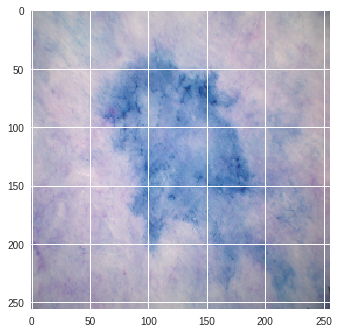

In [40]:
plt.imshow(melanoma_images[1])

In [12]:
file_root = 'drive/Dataset/gt'
ground_melanoma_images = []
for img in tqdm(os.listdir(file_root)):
    path = os.path.join(file_root,img)
    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256,256))
    ret,img = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    ground_melanoma_images.append(img)


 11%|█         | 214/2000 [03:41<30:48,  1.04s/it]

100%|██████████| 2000/2000 [30:03<00:00,  1.11it/s]


In [13]:
len(ground_melanoma_images)

2000

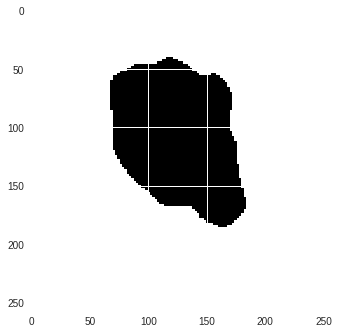

In [14]:
plt.imshow(ground_melanoma_images[6])

In [0]:
image=ground_melanoma_images[0]

In [43]:
image.shape

(256, 256)

In [44]:
np.unique(image)

array([  0, 255], dtype=uint8)

In [0]:
gt = np.array(ground_melanoma_images)

In [46]:
gt.shape

(2000, 256, 256)

In [47]:
np.unique(gt)

array([  0, 255], dtype=uint8)

In [0]:
gt=gt/255

In [49]:
np.unique(gt)

array([0., 1.])

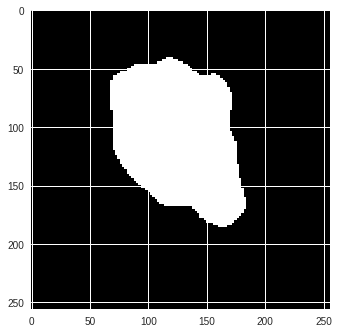

In [23]:
plt.imshow(gt[6],cmap = "gray")

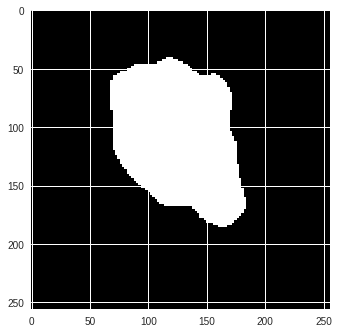

In [24]:
plt.imshow(ground_melanoma_images[6], cmap = "gray")

In [26]:
file_root = 'drive/Dataset/others'
other_images = []
for img in tqdm(os.listdir(file_root)):
    path = os.path.join(file_root,img)
    img = cv2.imread(path)
    img = cv2.resize(img, (256,256))
    other_images.append(img)

100%|██████████| 1627/1627 [32:42<00:00,  1.21s/it]


In [27]:
gt.shape

(2000, 256, 256)

In [50]:
total_image=[]
for i in tqdm(melanoma_images):
    total_image.append(i)

100%|██████████| 373/373 [00:00<00:00, 268257.10it/s]


In [51]:
for i in tqdm(other_images):
    total_image.append(i)

100%|██████████| 1627/1627 [00:00<00:00, 1313849.17it/s]


In [52]:
len(total_image)

2000

In [0]:
total_images = np.array(total_image)

In [54]:
total_images.shape

(2000, 256, 256, 3)

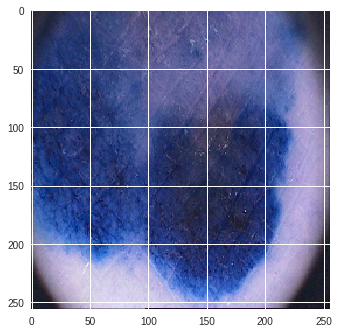

In [55]:
plt.imshow(total_images[10],cmap='gray')


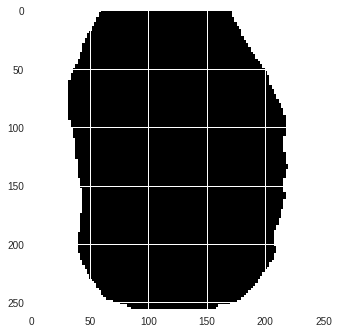

In [56]:
plt.imshow(gt[10])

In [57]:
total_images.shape

(2000, 256, 256, 3)

In [58]:
gt.shape

(2000, 256, 256)

In [0]:
np.save('drive/Dataset/total_images',total_images)

In [0]:
np.save('drive/Dataset/gt',gt)